In [61]:
import subprocess
import sys

from glob import glob
from itertools import combinations
from io import StringIO
from pathlib import Path

import great_expectations as gx
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torchaudio

from great_expectations.render.renderer import (
    ExpectationSuitePageRenderer,
    ValidationResultsPageRenderer,
)

from IPython.display import HTML, display
from matplotlib.legend_handler import HandlerTuple
from torchaudio.pipelines import SQUIM_OBJECTIVE
from torchinfo import summary
from tqdm import tqdm

from core.config import SAMPLE_RATE
from core.utils.great_expectations import generate_html

IS_WINDOWS = sys.platform.startswith("win")

dataset_folder = "data/nort3160"

gx_folder = "mlops/great_expectations"

subsets = ["train", "dev", "test"]

# Exploratory data analysis

## Overview

We are interested in LID for the [North Germanic](https://en.wikipedia.org/wiki/North_Germanic_languages) language sub-family, which comprises Danish, Faroese, Icelandic, Norwegian, and Swedish.

We will use the following corpuses:
 * [Common Voice 17.0](https://commonvoice.mozilla.org/), a crowd-sourcing effort which gathers recordings of native speakers in 100+ languages reading sentences from their language's Wikipedia
 * [FLEURS-R](https://www.arxiv.org/abs/2408.06227), an updated version of [FLEURS](https://arxiv.org/abs/2205.12446) which contains recordings of native speakers in 100+ languages reading sentences extracted (and translated) from the English Wikipedia
 * A subset of the [RAVNURSSON Corpus](https://huggingface.co/datasets/carlosdanielhernandezmena/ravnursson_asr), an ASR corpus for Faroese containing read utterances, whose text comprises various sources such as news, blogs, and Wikipedia.

For this project, we will group Norwegian Bokmål and Norwegian Nynorsk together under Norwegian. Although these are different forms of written Norwegian (see https://en.wikipedia.org/wiki/Norwegian_language), there is only one "official" Norwegian language (and we will not consider dialects in this project for simplicity).

We have prepared several scripts to download and prepare the above-mentioned datasets in the ```scripts``` folder. We show below the file structure:

In [62]:
# sudo apt install tree
!tree $dataset_folder --filelimit 40

data/nort3160
├── common_voice_17_0
│   ├── da
│   │   └── da
│   │       ├── audio
│   │       │   ├── dev  [2105 entries exceeds filelimit, not opening dir]
│   │       │   ├── test  [2531 entries exceeds filelimit, not opening dir]
│   │       │   └── train  [3484 entries exceeds filelimit, not opening dir]
│   │       ├── dev.tsv
│   │       ├── test.tsv
│   │       └── train.tsv
│   ├── is
│   │   └── is
│   │       ├── audio
│   │       │   ├── dev
│   │       │   ├── test
│   │       │   └── train
│   │       │       ├── common_voice_is_37051265.mp3
│   │       │       ├── common_voice_is_37051266.mp3
│   │       │       ├── common_voice_is_37051268.mp3
│   │       │       ├── common_voice_is_37051269.mp3
│   │       │       ├── common_voice_is_37051280.mp3
│   │       │       ├── common_voice_is_37051281.mp3
│   │       │       ├── common_voice_is_37051282.mp3
│   │       │       ├── common_voice_is_37051283.mp3
│   │       │       ├── common_voice_is_37051284.mp3
│   │       │

### Language codes

Each dataset uses, unfortunately, different codes to represent the languages. Using Glottolog, we have semi-manually reconstructed a table to show the different codes and languages available in each dataset.

In [63]:
codes = pd.read_csv("data/languages/nort3160.csv", index_col=0)

codes

,fleurs-r,common_voice_17_0,ravnursson,glottolog
language,,,,
Danish,da_dk,da,NaN,dani1285
Faroese,NaN,NaN,fo,faro1244
Icelandic,is_is,is,NaN,icel1247
Norwegian,nb_no,nn-NO,NaN,norw1258
Swedish,sv_se,sv-SE,NaN,swed1254


In [64]:
stacked_codes = codes.drop("glottolog", axis=1).stack().droplevel(1, axis=0)

language2code = stacked_codes.groupby(stacked_codes.index).apply(list).to_dict()

print(language2code)

code2language = (
    stacked_codes
    .reset_index()
    .set_index(0)
    .to_dict()["language"]
)

code2language

{'Danish': ['da_dk', 'da'], 'Faroese': ['fo'], 'Icelandic': ['is_is', 'is'], 'Norwegian': ['nb_no', 'nn-NO'], 'Swedish': ['sv_se', 'sv-SE']}


{'da_dk': 'Danish',
 'da': 'Danish',
 'fo': 'Faroese',
 'is_is': 'Icelandic',
 'is': 'Icelandic',
 'nb_no': 'Norwegian',
 'nn-NO': 'Norwegian',
 'sv_se': 'Swedish',
 'sv-SE': 'Swedish'}

## Data imbalance

* We see that there is large imbalance in the chosen corpus. For instance, Swedish contains ~20x more samples than Icelandic. Moreover, the dataset is not representative of the number of speakers for these languages [source](https://en.wikipedia.org/wiki/North_Germanic_languages#Demographics); Norwegian is clearly underrpresented, while Faroese is extremely overrepresented due to the addition of the Ravnursson dataset.

* However, most models that we will used have been pre-trained on [VoxLingua107](https://bark.phon.ioc.ee/voxlingua107/), a large speech corpus that contains 34 hours of Swedish, 164 hours of Norwegian (107 of Bokmaal and 57 of Nynorsk), 92 hours of Icelandic, 28 hours of Danish, and 67 hours of Faroese. This pre-training on a more balanced corpus may help mitigate the effects of the imbalance in our chosen corpus to some extent.

In [65]:
stats = {}

datasets = ["fleurs-r", "common_voice_17_0", "ravnursson"]

for dataset in datasets:
    for i, subset in enumerate(subsets):
        stats[f"{dataset}/{subset}"] = {}
        language_paths = glob(f"{dataset_folder}/{dataset}/*/*")
        for language_path in language_paths:
            stats[f"{dataset}/{subset}"][code2language[Path(language_path).stem]] = len(
                glob(f"{language_path}/audio/{subset}/*")
            )

stats_df = pd.DataFrame(stats).sort_index()

stats_df

,fleurs-r/train,fleurs-r/dev,fleurs-r/test,common_voice_17_0/train,common_voice_17_0/dev,common_voice_17_0/test,ravnursson/train,ravnursson/dev,ravnursson/test
Danish,2182.0,394.0,925.0,3484.0,2105.0,2531.0,NaN,NaN,NaN
Faroese,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,3331.0,3002.0
Icelandic,923.0,36.0,46.0,14.0,0.0,0.0,NaN,NaN,NaN
Norwegian,2322.0,161.0,356.0,515.0,283.0,371.0,NaN,NaN,NaN
Swedish,2371.0,330.0,755.0,7744.0,5210.0,5260.0,NaN,NaN,NaN


In [66]:
stats_df.sum(1)

Danish       11621.0
Faroese      16333.0
Icelandic     1019.0
Norwegian     4008.0
Swedish      21670.0
dtype: float64

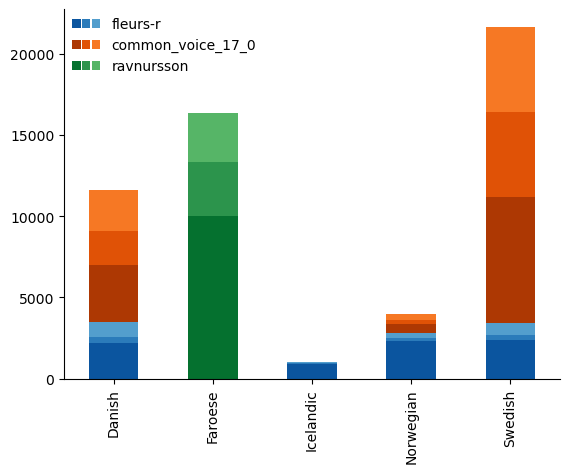

In [67]:
stats_df.plot.bar(
    stacked=True,
    color=[
        *sns.color_palette("Blues_r").as_hex()[:3],
        *sns.color_palette("Oranges_r").as_hex()[:3],
        *sns.color_palette("Greens_r").as_hex()[:3],
    ],
)

all_containers = []

colors = []

for container in plt.gca().containers:
    for c in container:
        c_color = c.get_facecolor()
        if not c_color in colors:
            all_containers.append(c)
            colors.append(c_color)

all_containers = tuple(all_containers)

handles, labels = plt.gca().get_legend_handles_labels()

plt.gca().legend(
    [all_containers[:3], all_containers[3:6], all_containers[6:]], datasets, handler_map={tuple: HandlerTuple(ndivide=None)}, borderpad=.1, frameon=False
)
sns.despine()
plt.show()

## Duplicates

As a speech corpus, our data does not have missing values per se, but we will check that files are not empty.

To examine duplicates, we will assume that the files have been correctly labelled, as they come from trusted and public sources which can be fact-checked (all published in Huggingface), and we do not have ourselves the expertise to fact-check that the labelling.

Thus, we will examine the possibility of within-language duplicates.



### File sizes with great expectations

A first easy step in examining duplicates is looking at file sizes, durations (and sample rates).

We will look at the Danish language as an example here.

In [68]:
for language, codes in language2code.items():
    durations = []
    samplerates = []
    file_sizes = []
    files = []
    for code in codes:
        pattern = f"{dataset_folder}/*/{code}/{code}/audio/*/"
        try:
            # Some datasets have .wav, others .mp3
            ext = "wav"
            ls = subprocess.run(
                f"ls -l {pattern}*.{ext}", capture_output=True, shell=not IS_WINDOWS, check=True
            )
            # sorted ensures the file order will be similar to the ls -l call
        except subprocess.CalledProcessError:
            ext = "mp3"
            ls = subprocess.run(
                f"ls -l {pattern}*.{ext}", capture_output=True, shell=not IS_WINDOWS, check=True
            )

        # Get file sizes as a DataFrame
        code_file_sizes, code_files = pd.read_csv(
            StringIO(ls.stdout.decode("utf-8").replace("   ", " ").replace("  ", " ")),
            sep=" ",
            header=None,
            # on_bad_lines="warn",
        ).iloc[:, [4, 8]].values.T

        for audio in tqdm(code_files, desc=f"{language} ({code})"):
            # Get audio metadata using librosa
            sr = librosa.get_samplerate(audio)
            durations.append(librosa.get_duration(path=audio, sr=sr))
            samplerates.append(sr)

        file_sizes.extend(code_file_sizes)
        files.extend([Path(x).stem for x in code_files])

    # Bundle everything into a DataFrame
    sizes_and_durations = pd.DataFrame(
        {
            "file": files,
            "filesize": file_sizes,
            "duration": durations,
            "samplerate": samplerates
        }
    )

    sizes_and_durations.to_csv(f"data/stats/sizes_and_durations_{language}.csv")

Danish (da_dk):   0%|          | 0/3501 [00:00<?, ?it/s]

Danish (da_dk):  77%|███████▋  | 2711/3501 [00:00<00:00, 8066.64it/s]


KeyboardInterrupt: 

In [30]:
language = "Danish"

danish_audiometa_df = gx.read_csv(
    f"data/stats/sizes_and_durations_{language}.csv",
    index_col=0
)

# Expectations on audio duration
danish_audiometa_df.expect_column_values_to_not_be_null("duration")
danish_audiometa_df.expect_column_values_to_be_of_type("duration", "float")
danish_audiometa_df.expect_column_values_to_be_between(
    "duration", min_value=1, max_value=60
)
danish_audiometa_df.expect_column_values_to_be_unique("duration")

# Expectations on sample rate
danish_audiometa_df.expect_column_values_to_not_be_null("samplerate")
danish_audiometa_df.expect_column_distinct_values_to_be_in_set(
    "samplerate", {16000, 24000, 32000, 48000}
)

# Expectations on file size
danish_audiometa_df.expect_column_values_to_not_be_null("filesize")
danish_audiometa_df.expect_column_values_to_be_of_type("filesize", "int")
danish_audiometa_df.expect_column_values_to_be_unique("filesize")
# https://pamaproaudio.com/free-audio-file-size-calculator/
danish_audiometa_df.expect_column_values_to_be_between(
    "filesize", min_value=2000, max_value=21.6e6
)

# Expectations on file name
danish_audiometa_df.expect_column_values_to_not_be_null("file")
danish_audiometa_df.expect_column_values_to_be_unique("file")

validation_results = danish_audiometa_df.validate()

expectation_suite = danish_audiometa_df.get_expectation_suite(
    discard_failed_expectations=False
)

danish_audiometa_df.save_expectation_suite(
    f"{gx_folder}/expectation_suite_{language}.json", discard_failed_expectations=False
)

In [31]:
generate_html(
    validation_results,
    ValidationResultsPageRenderer(),
    f"{gx_folder}/validation_result_{language}.html",
)
generate_html(
    expectation_suite,
    ExpectationSuitePageRenderer(),
    f"{gx_folder}/expectation_suite_{language}.html",
)

html_path = f"mlops/great_expectations/validation_result_{language}.html"

display(HTML(filename=html_path))

,
Evaluated Expectations,12
Successful Expectations,10
Unsuccessful Expectations,2
Success Percent,≈83.33%
,
Great Expectations Version,0.18.17
Run Name,__none__
Run Time,2024-10-26T14:39:40Z
,
ge_batch_id,2238042e-93a8-11ef-b242-581122c5fc07


In [13]:
danish_audiometa_df.filesize.value_counts()

filesize
27261      85
22293      82
24021      82
20133      80
24453      78
           ..
1407404     1
44109       1
45837       1
975404      1
967724      1
Name: count, Length: 723, dtype: int64

In [14]:
danish_audiometa_df.query("filesize == 27261")

,file,filesize,duration,samplerate
3572,common_voice_da_28368417,27261,4.5435,32000
3593,common_voice_da_28368679,27261,4.5435,32000
3628,common_voice_da_28369029,27261,4.5435,32000
3648,common_voice_da_28369439,27261,4.5435,32000
3661,common_voice_da_28369497,27261,4.5435,32000
...,...,...,...,...
10781,common_voice_da_34922012,27261,4.5435,32000
10846,common_voice_da_35153748,27261,4.5435,32000
11213,common_voice_da_36594998,27261,4.5435,32000
11257,common_voice_da_36595128,27261,4.5435,32000


* We see that all audio with identical file sizes (and durations) from the Common Voice dataset

In [15]:
danish_audiometa_df.query("filesize == 27261").file.apply(lambda x: x.split("_")[:2]).describe()

count                  85
unique                  1
top       [common, voice]
freq                   85
Name: file, dtype: object

### Common Voice duplicates?

To double-check potential duplicates, we can look at the metadata provided with the datasets upon download using Hugging Face.

In [16]:
gender_balance = {}

for language, codes in language2code.items():
    for code in codes:
        # 1 tsv per subset (train/dev/test)
        tsvs = glob(f"{dataset_folder}/*/{code}/{code}/*.tsv")

        dfs = []

        speaker_ids = {}

        dataset = None

        for tsv in tsvs:
            if "fleurs-r" in tsv:
                # FLEURS .tsv files do not have headers
                # So we manually add them
                subset_df = pd.read_csv(tsv, sep="\t", header=None)
                subset_df.columns = [
                    "sentence_index",
                    "fname",
                    "sentence",
                    "sentence_lower",
                    "chars",
                    "num_samples",
                    "gender",
                ]
                # Speaker ID not available: https://huggingface.co/datasets/google/fleurs/discussions/7
                speaker_ids[Path(tsv).stem] = set()
                dataset = "fleurs-r"
            else:
                subset_df = pd.read_csv(tsv, sep="\t")
                if "common_voice" in tsv:
                    speaker_ids[Path(tsv).stem] = set(subset_df.client_id.to_list())
                    dataset = "common_voice_17_0"
                elif "ravnursson" in tsv:
                    speaker_ids[Path(tsv).stem] = set(subset_df.speaker_id.to_list())
                    dataset = "ravnursson"
            dfs.append(subset_df)

        concat_df = pd.concat(dfs, axis=0)

        assert concat_df.duplicated().sum() == 0 # never fails

        for (subset1, subset2) in combinations(subsets, 2):
            speaker_id_intersection = speaker_ids[subset1].intersection(
                speaker_ids[subset2]
            )
            n_intersection = len(speaker_id_intersection)
            assert n_intersection == 0
            if n_intersection > 0:
                print(f"{dataset} ({code}) - found {n_intersection} common speakers in {subset1} and {subset2} sets: {speaker_id_intersection}")

        gender_balance_subset = concat_df.gender.value_counts(normalize=True)

        gender_balance[f"{dataset}/{language}"] = concat_df.gender.value_counts(normalize=True, dropna=False).rename(index={k: k.capitalize().split("_")[0] for k in gender_balance_subset.index})

```assert concat_df.duplicated().sum() == 0``` never failed, indicating that there are no duplicated rows in the dataset. This is especially important as it means that we are not directly leaking data in the subsets.

```assert n_intersection == 0``` never failed, meaning that there is no speaker data leakage in Common Voice and Ravnursson. However, because this information is not provided in FLEURS, we cannot confirm that there is no leakage.

Surprisingly, the file sizes and durations are not unique. A way to settle the doubt for clear duplicates is to look at the spectrograms.

## Gender balance

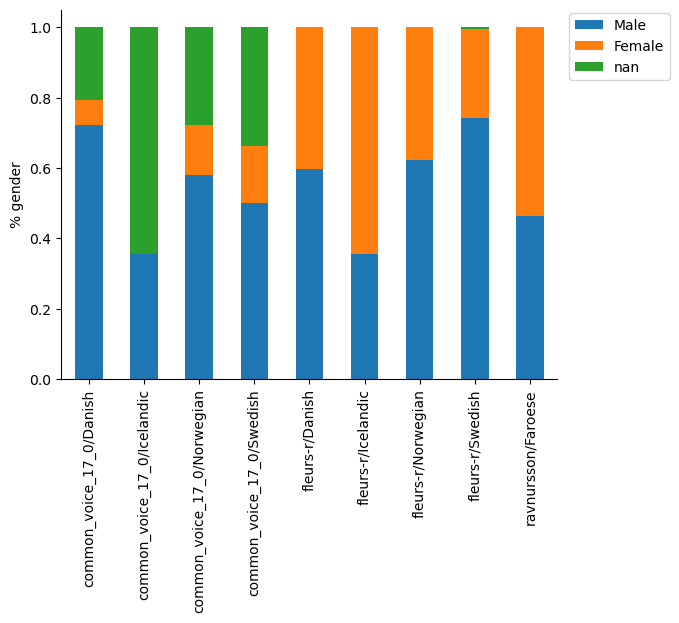

In [17]:
gender_balance_df = pd.DataFrame.from_dict(gender_balance, orient="index").sort_index()
gender_balance_df.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.ylabel("% gender")
sns.despine()
plt.show()

* Most datasets are reasonably will balanced; exceptions are Common Voice/Danish (72% Male), Common Voice/Icelandic (although 64% declined to declare their gender), and FLEURS-R/Swedish (74% Male). Proper gender balancing could be ensured by augmenting the datasets, e.g. with the NST dataset (https://www.nb.no/sprakbanken/en/resource-catalogue/oai-nb-no-sbr-55)

In [128]:
gender_balance_df.T.agg(["max", "idxmax"]).T.sort_values(by="max", ascending=False)

,max,idxmax
fleurs-r/Swedish,0.743634,Male
common_voice_17_0/Danish,0.722737,Male
fleurs-r/Icelandic,0.643781,Female
common_voice_17_0/Icelandic,0.642857,NaN
fleurs-r/Norwegian,0.622402,Male
fleurs-r/Danish,0.596687,Male
common_voice_17_0/Norwegian,0.581336,Male
ravnursson/Faroese,0.537011,Female
common_voice_17_0/Swedish,0.499808,Male


## Audio quality

In [54]:
# SQUIM does not require the corresponding clean speech as reference for speech assessment
objective_model = SQUIM_OBJECTIVE.get_model()

torch.compile(objective_model)

is_cuda = torch.cuda.is_available()

# if is_cuda:
#     objective_model.to("cuda:0")

summary(objective_model)

Layer (type:depth-idx)                                            Param #
SquimObjective                                                    --
├─Encoder: 1-1                                                    --
│    └─Conv1d: 2-1                                                16,384
├─DPRNN: 1-2                                                      --
│    └─ModuleList: 2-2                                            --
│    │    └─SingleRNN: 3-1                                        1,184,000
│    │    └─SingleRNN: 3-2                                        1,184,000
│    └─ModuleList: 2-3                                            --
│    │    └─SingleRNN: 3-3                                        1,184,000
│    │    └─SingleRNN: 3-4                                        1,184,000
│    └─ModuleList: 2-4                                            --
│    │    └─GroupNorm: 3-5                                        512
│    │    └─GroupNorm: 3-6                                       

In [47]:
exts = ("wav", "mp3")

base_pattern = f"{dataset_folder}/**/audio"

audio_files = []

for ext in exts:
    audio_files.extend(glob(f"{base_pattern}/*/*.{ext}", recursive=True))

print(len(audio_files))

54648


In [55]:
sq_data = {}


for file in tqdm(audio_files):
    x, sr = torchaudio.load(file)

    if sr != SAMPLE_RATE:
        x = torchaudio.functional.resample(x, sr, SAMPLE_RATE)

    stoi, pesq, si_sdr = objective_model(
        x[0:1]
    )

    sq_data[file] = {"stoi": stoi, "pesq": pesq, "si_sdr": si_sdr}

  0%|          | 0/54648 [00:00<?, ?it/s]

  0%|          | 69/54648 [00:23<5:13:48,  2.90it/s]


KeyboardInterrupt: 

In [60]:
pd.DataFrame.from_dict(sq_data, orient="index")

,stoi,pesq,si_sdr
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/7628391443643264437.wav,"[tensor(0.9975, grad_fn=<UnbindBackward0>)]","[tensor(3.8072, grad_fn=<UnbindBackward0>)]","[tensor(29.9693, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/11084784542750961121.wav,"[tensor(0.9865, grad_fn=<UnbindBackward0>)]","[tensor(2.8321, grad_fn=<UnbindBackward0>)]","[tensor(14.2719, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/14713311937288361621.wav,"[tensor(0.9970, grad_fn=<UnbindBackward0>)]","[tensor(3.9032, grad_fn=<UnbindBackward0>)]","[tensor(17.5652, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/12520163232449391899.wav,"[tensor(0.9981, grad_fn=<UnbindBackward0>)]","[tensor(4.0877, grad_fn=<UnbindBackward0>)]","[tensor(27.8409, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/3964704728058563250.wav,"[tensor(0.9954, grad_fn=<UnbindBackward0>)]","[tensor(3.7706, grad_fn=<UnbindBackward0>)]","[tensor(21.8881, grad_fn=<UnbindBackward0>)]"
...,...,...,...
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/782459723842126581.wav,"[tensor(0.9843, grad_fn=<UnbindBackward0>)]","[tensor(3.4679, grad_fn=<UnbindBackward0>)]","[tensor(17.9279, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/18222845534180441903.wav,"[tensor(0.9931, grad_fn=<UnbindBackward0>)]","[tensor(3.8099, grad_fn=<UnbindBackward0>)]","[tensor(23.0435, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/14892008184251939742.wav,"[tensor(0.9984, grad_fn=<UnbindBackward0>)]","[tensor(3.8671, grad_fn=<UnbindBackward0>)]","[tensor(20.1870, grad_fn=<UnbindBackward0>)]"
data/nort3160/fleurs-r/da_dk/da_dk/audio/test/9868267402015029944.wav,"[tensor(0.9965, grad_fn=<UnbindBackward0>)]","[tensor(3.9880, grad_fn=<UnbindBackward0>)]","[tensor(29.1143, grad_fn=<UnbindBackward0>)]"


In [34]:
sq_data = {}

for language, codes in language2code.items():
    for code in codes:
        sq_data[f"{language}/"]
        pattern = f"{dataset_folder}/*/{code}/{code}/audio/*"

        code_files = sorted(glob(f"{pattern}/*.wav")) + sorted(glob(f"{pattern}/*.mp3"))

        for cf in tqdm(code_files, desc=f"{language} ({code})"):
            x, sr = torchaudio.load(cf)

            if sr != SAMPLE_RATE:
                x = torchaudio.functional.resample(x, sr, SAMPLE_RATE)

            stoi, pesq, si_sdr = objective_model(
                x[0:1]
            )



Danish (da_dk):   0%|          | 0/3501 [00:00<?, ?it/s]

Danish (da_dk):   0%|          | 0/3501 [00:00<?, ?it/s]


AssertionError: 